In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

proj_root = os.path.dirname(os.path.abspath("."))
# print(proj_root)
sys.path.append(proj_root)

import time
import datetime
import torch
import random
import numpy as np
import os
from pathlib import Path
import argparse

import torch.optim as optim
import torch.nn.functional as F

import gym
import yaml

from minatar_dqn.my_dqn import AgentDQN
from minatar_dqn.replay_buffer import ReplayBuffer
from minatar_dqn.utils.my_logging import setup_logger
from minatar_dqn.models import Conv_QNET, Conv_QNET_one

from experiments.experiment_utils import (
    seed_everything,
    search_files_containing_string,
    split_path_at_substring,
    collect_training_output_files,
)

from minatar_dqn.my_dqn import Conv_QNET, build_environment
from minatar_dqn.redo import (
    apply_redo_parametrization,
    reset_optimizer_states,
    map_layers_to_optimizer_indices,
)
from experiments.experiment_utils import (
    collect_training_output_files,
    collect_pruning_output_files,
)

from experiments.training.training import read_config_files, get_config_paths

from flatten_dict import flatten
import pandas as pd
import seaborn as sns
import scipy

sns.set()

import plotly

plotly.io.kaleido.scope.mathjax = None

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Setup config
root_dir = os.path.dirname(os.path.abspath("."))

path_experiments_configs = os.path.join(
    root_dir, "experiments", "training", "training_configs"
)
path_experiments_outputs = os.path.join(root_dir, "experiments", "training", "outputs")

default_config_path, experiment_config_paths = get_config_paths(
    path_experiments_configs
)

experiment_configs = read_config_files(default_config_path, experiment_config_paths)

experiment_configs[0]

{'epochs_to_train': 20,
 'seeds': [0],
 'environments': ['breakout'],
 'agent_params': {'agent': 'AgentDQN',
  'args_': {'train_step_cnt': 200000,
   'validation_enabled': True,
   'validation_step_cnt': 125000,
   'validation_epsilon': 0.001,
   'replay_start_size': 5000,
   'batch_size': 32,
   'training_freq': 4,
   'target_model_update_freq': 100,
   'loss_fcn': 'mse_loss',
   'gamma': 0.99,
   'epsilon': {'start': 1.0, 'end': 0.01, 'decay': 250000}}},
 'estimator': {'model': 'Conv_QNET',
  'args_': {'conv_hidden_out_size': 32, 'lin_hidden_out_size': 128}},
 'optim': {'name': 'Adam', 'args_': {'lr': 6.25e-05, 'eps': 0.00015}},
 'replay_buffer': {'max_size': 100000, 'action_dim': 1, 'n_step': 0},
 'redo': {'attach': True,
  'enabled': False,
  'tau': 0.1,
  'beta': 1,
  'redo_freq': 1000,
  'selection_option': None},
 'reward_perception': None,
 'experiment_name': 'conv32_lin128'}

In [4]:
config = experiment_configs[0]
config["environment"] = "breakout"
config["seed"] = 0

output_path = os.path.join(
    root_dir,
    "experiments",
    "redo",
)

In [5]:
config

{'epochs_to_train': 20,
 'seeds': [0],
 'environments': ['breakout'],
 'agent_params': {'agent': 'AgentDQN',
  'args_': {'train_step_cnt': 200000,
   'validation_enabled': True,
   'validation_step_cnt': 125000,
   'validation_epsilon': 0.001,
   'replay_start_size': 5000,
   'batch_size': 32,
   'training_freq': 4,
   'target_model_update_freq': 100,
   'loss_fcn': 'mse_loss',
   'gamma': 0.99,
   'epsilon': {'start': 1.0, 'end': 0.01, 'decay': 250000}}},
 'estimator': {'model': 'Conv_QNET',
  'args_': {'conv_hidden_out_size': 32, 'lin_hidden_out_size': 128}},
 'optim': {'name': 'Adam', 'args_': {'lr': 6.25e-05, 'eps': 0.00015}},
 'replay_buffer': {'max_size': 100000, 'action_dim': 1, 'n_step': 0},
 'redo': {'attach': True,
  'enabled': False,
  'tau': 0.1,
  'beta': 1,
  'redo_freq': 1000,
  'selection_option': None},
 'reward_perception': None,
 'experiment_name': 'conv32_lin128',
 'environment': 'breakout',
 'seed': 0}

In [6]:
config["agent_params"]["args_"]["train_step_cnt"] = 20000
config["agent_params"]["args_"]["validation_step_cnt"] = 12500
config["redo"]["beta"] = 1
config["redo"]["tau"] = 0.025

In [7]:
env_name = config["environment"]

logger = setup_logger(
    env_name=env_name,
    identifier_string="redo_test_experiment",
)
logger.info(
    f'Starting up experiment: {config["experiment_name"]}, environment: {config["environment"]}, seed: {config["seed"]}'
)

### Setup environments ###
train_env = build_environment(
    game_name=config["environment"], random_seed=config["seed"]
)
validation_env = build_environment(
    game_name=config["environment"], random_seed=config["seed"]
)

experiment_agent = AgentDQN(
    train_env=train_env,
    validation_env=validation_env,
    experiment_output_folder=output_path,
    experiment_name="redo_test_experiment",
    resume_training_path=None,
    save_checkpoints=True,
    logger=logger,
    config=config,
)

2023-11-06 15:41:01,503 - root - INFO - redo_test_experiment - Starting up experiment: conv32_lin128, environment: breakout, seed: 0
2023-11-06 15:41:01,516 - root - INFO - redo_test_experiment - Loaded configuration settings.
2023-11-06 15:41:01,528 - root - INFO - redo_test_experiment - Initialized newtworks and optimizer.
2023-11-06 15:41:01,529 - root - INFO - redo_test_experiment - Applied redo parametrization to policy model.
2023-11-06 15:41:01,529 - root - INFO - redo_test_experiment - Applied redo parametrization to target model.


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning:

WARN: The environment MinAtar/Breakout-v0 is out of date. You should consider upgrading to version `v1`.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning:

WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning:

WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.



In [8]:
experiment_agent.train(train_epochs=10)

2023-11-06 15:41:01,596 - root - INFO - redo_test_experiment - Starting training session at: 0
2023-11-06 15:41:01,596 - root - INFO - redo_test_experiment - Starting training epoch at t = 0


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)



2023-11-06 15:41:27,956 - root - INFO - redo_test_experiment - TRAINING STATS | Frames seen: 20000 | Episode: 1812 | Max reward: 5.0 | Avg reward: 0.49337748344370863 | Avg frames (episode): 11.032008830022075 | Avg max Q: -73.95670732657115 | Epsilon: 0.9406 | Train epoch time: 0:00:26.354920
2023-11-06 15:41:27,957 - root - INFO - redo_test_experiment - Starting validation epoch at t = 20000
2023-11-06 15:41:33,995 - root - INFO - redo_test_experiment - VALIDATION STATS | Max reward: 1.0 | Avg reward: 0.5053003533568905 | Avg frames (episode): 11.053003533568905 | Avg max Q: -87.74112539280699 | Validation epoch time: 0:00:06.035503
2023-11-06 15:41:33,996 - root - INFO - redo_test_experiment - Saving checkpoint at t = 20000 ...
2023-11-06 15:41:34,025 - root - DEBUG - redo_test_experiment - Models saved at t = 20000
2023-11-06 15:41:34,043 - root - DEBUG - redo_test_experiment - Training status saved at t = 20000
2023-11-06 15:41:35,641 - root - INFO - redo_test_experiment - Checkpo

True

In [9]:
# collect a set of states to check Q on before and after redo

eval_states = []

samples_nr = 100
skip_nr = 100
for i in range(samples_nr):
    for j in range(skip_nr):
        # get a random action from the environment
        action = experiment_agent.train_env.action_space.sample()
        s_prime, reward, is_terminated, truncated, info = experiment_agent.train_env.step(
            action
        )
        s_prime = torch.tensor(s_prime, device="cpu").float()

        if is_terminated:
            experiment_agent.train_env.reset()
            continue

    eval_states.append(s_prime)

In [10]:
import copy

eval_states_tensor = torch.stack(eval_states)

predictions_init = experiment_agent.policy_model(eval_states_tensor)
predictions_init

max_q_vals_init = []
for state in eval_states_tensor:
    max_q_val = experiment_agent.get_max_q_val_for_state(state.unsqueeze(0))
    max_q_vals_init.append(max_q_val)

# get the weights before redo
state_dict_init = copy.deepcopy(experiment_agent.policy_model.state_dict())

In [11]:
redo_scores = experiment_agent.policy_model.get_dormant_scores()
redo_scores

[tensor([0.0249, 0.0209, 0.0473, 0.0613, 0.0320, 0.0635, 0.0132, 0.0629, 0.0382,
         0.0144, 0.0226, 0.0092, 0.0545, 0.0234, 0.0312, 0.0193, 0.0140, 0.0587,
         0.0071, 0.0146, 0.0387, 0.0596, 0.0056, 0.0198, 0.0407, 0.0096, 0.0022,
         0.0267, 0.0328, 0.0162, 0.0852, 0.0297]),
 tensor([0.0322, 0.0272, 0.0291, 0.0265, 0.0295, 0.0289, 0.0315, 0.0295, 0.0303,
         0.0345, 0.0333, 0.0262, 0.0315, 0.0295, 0.0346, 0.0280, 0.0328, 0.0255,
         0.0309, 0.0625, 0.0332, 0.0351, 0.0322, 0.0321, 0.0341, 0.0307, 0.0286,
         0.0244, 0.0248, 0.0296, 0.0251, 0.0360]),
 tensor([0.0000, 0.0302, 0.0000, 0.0000, 0.0277, 0.0000, 0.0321, 0.0000, 0.0000,
         0.0173, 0.0000, 0.0188, 0.0375, 0.0310, 0.0115, 0.0408, 0.0000, 0.0025,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0471, 0.0000, 0.0208, 0.0000, 0.0178,
         0.0000, 0.0000, 0.0000, 0.0105, 0.0000, 0.0293, 0.0000, 0.0000, 0.0313,
         0.0000, 0.0173, 0.0361, 0.0109, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       

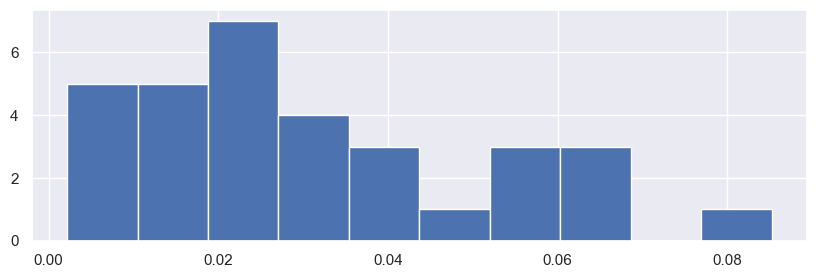

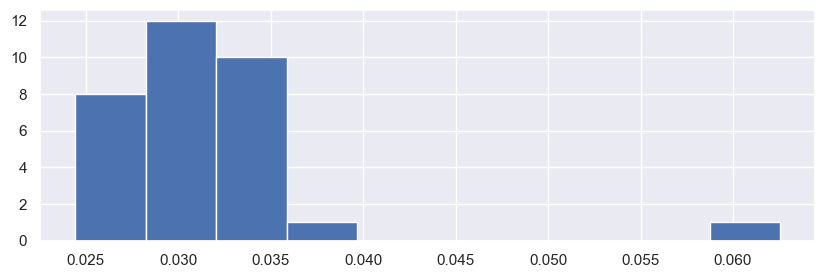

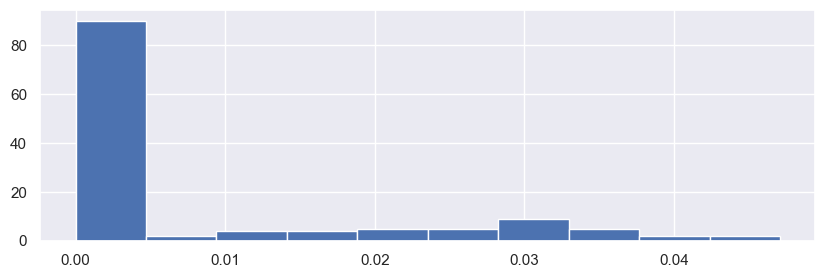

In [24]:
# Histogram of redo_scores
for scores in redo_scores:
    fig = plt.figure(figsize=(10, 3))
    plt.hist(scores)
    plt.show()


In [12]:
# apply redo
reset_details = experiment_agent.policy_model.apply_redo()
reset_details

[{'indexes': tensor([ 0,  1,  6,  9, 10, 11, 13, 15, 16, 18, 19, 22, 23, 25, 26, 29]),
  'inbound': 'features.conv1',
  'outbound': 'features.conv2'},
 {'indexes': tensor([27, 28]),
  'inbound': 'features.conv2',
  'outbound': 'fc.lin1'},
 {'indexes': tensor([  0,   2,   3,   5,   7,   8,   9,  10,  11,  14,  16,  17,  18,  19,
           20,  21,  23,  24,  25,  26,  27,  28,  29,  30,  31,  33,  34,  36,
           37,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
           52,  53,  54,  56,  58,  59,  60,  62,  63,  64,  66,  67,  68,  69,
           70,  71,  72,  74,  75,  77,  78,  79,  80,  81,  82,  83,  85,  86,
           87,  88,  89,  90,  91,  94,  95,  97,  98,  99, 100, 101, 102, 103,
          104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119,
          120, 121, 123, 124, 125, 126, 127]),
  'inbound': 'fc.lin1',
  'outbound': 'fc.lin2'}]

In [13]:
layer_to_optim_idx = map_layers_to_optimizer_indices(
    experiment_agent.policy_model, experiment_agent.optimizer
)
layer_to_optim_idx

reset_optimizer_states(reset_details, experiment_agent.optimizer, layer_to_optim_idx)

In [14]:
# get the difference between the values before and after
predictions_after = experiment_agent.policy_model(eval_states_tensor)
predictions_after

max_q_vals_after = []
for state in eval_states_tensor:
    max_q_val = experiment_agent.get_max_q_val_for_state(state.unsqueeze(0))
    max_q_vals_after.append(max_q_val)

# get the weights before redo
state_dict_after = experiment_agent.policy_model.state_dict()

In [15]:
predictions_after

tensor([[-31.2946, -42.5488, -37.0230, -26.6500, -34.0553, -36.5199],
        [-26.5324, -34.7855, -31.6515, -24.4279, -28.8428, -30.9583],
        [-32.4035, -42.7396, -38.6483, -29.4967, -35.3731, -37.8596],
        [-26.3285, -34.4326, -31.3431, -23.7949, -28.5638, -30.6073],
        [-30.0798, -40.0979, -35.8420, -26.9421, -32.7823, -35.0896],
        [-27.7390, -36.3286, -32.8638, -23.9712, -30.1473, -32.1476],
        [-29.3061, -38.3750, -34.9569, -27.6229, -31.6856, -34.2210],
        [-29.7949, -39.9772, -35.3913, -27.0161, -32.1911, -34.7896],
        [-29.0592, -38.9971, -33.9719, -23.9730, -31.2678, -33.6350],
        [-24.7986, -32.7064, -29.6068, -23.0987, -26.8859, -28.9567],
        [-29.8906, -39.6377, -35.3367, -25.5781, -32.5104, -34.6844],
        [-29.2320, -39.4646, -34.5926, -25.0766, -31.7544, -34.0991],
        [-25.6402, -33.5435, -30.5278, -23.5204, -27.7728, -29.8537],
        [-29.0561, -38.4676, -34.3153, -24.6937, -31.5669, -33.6959],
        [-27.7390, -

In [16]:
diff = np.array(max_q_vals_init) - np.array(max_q_vals_after)
sum(diff)

-3363.0996170043945

In [17]:
max_q_vals_init

[-56.56591796875,
 -58.75151824951172,
 -78.36463165283203,
 -55.33132553100586,
 -70.22177124023438,
 -50.94410705566406,
 -61.46672058105469,
 -58.84042739868164,
 -54.52519607543945,
 -56.30188751220703,
 -66.37553405761719,
 -49.8223876953125,
 -56.19443893432617,
 -60.06779098510742,
 -50.94410705566406,
 -60.06779098510742,
 -53.881744384765625,
 -80.32144165039062,
 -55.31972122192383,
 -77.71903991699219,
 -58.24412155151367,
 -61.46672058105469,
 -53.225982666015625,
 -57.14405059814453,
 -65.43023681640625,
 -54.52519607543945,
 -51.529945373535156,
 -48.75208282470703,
 -60.005218505859375,
 -54.52519607543945,
 -53.881744384765625,
 -48.87445831298828,
 -52.95625686645508,
 -57.1031608581543,
 -64.97799682617188,
 -50.2724609375,
 -53.881744384765625,
 -66.41050720214844,
 -72.69422912597656,
 -58.84042739868164,
 -68.70306396484375,
 -69.97803497314453,
 -58.24412155151367,
 -54.991004943847656,
 -66.41050720214844,
 -53.881744384765625,
 -65.05097198486328,
 -66.410507202

In [18]:
max_q_vals_after

[-26.649988174438477,
 -24.4278507232666,
 -29.496658325195312,
 -23.7949275970459,
 -26.94208335876465,
 -23.971160888671875,
 -27.62288475036621,
 -27.016122817993164,
 -23.973024368286133,
 -23.098730087280273,
 -25.5781307220459,
 -25.07659912109375,
 -23.52044105529785,
 -24.69374656677246,
 -23.971160888671875,
 -24.69374656677246,
 -24.073972702026367,
 -29.316478729248047,
 -26.612672805786133,
 -25.7737979888916,
 -24.17511558532715,
 -27.62288475036621,
 -22.712186813354492,
 -25.412960052490234,
 -25.697830200195312,
 -23.973024368286133,
 -24.114179611206055,
 -23.806312561035156,
 -27.238967895507812,
 -23.973024368286133,
 -24.073972702026367,
 -27.662391662597656,
 -23.531696319580078,
 -23.602445602416992,
 -25.83378028869629,
 -24.940269470214844,
 -24.073972702026367,
 -25.47007179260254,
 -27.132837295532227,
 -27.016122817993164,
 -26.101415634155273,
 -26.132335662841797,
 -24.17511558532715,
 -27.019590377807617,
 -25.47007179260254,
 -24.073972702026367,
 -26.207

In [19]:
for layer in state_dict_after:
    if not torch.equal(state_dict_init[layer], state_dict_after[layer]):
        print(f"Weights changed in layer: {layer}")

Weights changed in layer: features.conv1.weight
Weights changed in layer: features.conv1.bias
Weights changed in layer: features.relu1.running_avg
Weights changed in layer: features.relu1.running_avg_cnt
Weights changed in layer: features.conv2.weight
Weights changed in layer: features.conv2.bias
Weights changed in layer: features.relu2.running_avg
Weights changed in layer: features.relu2.running_avg_cnt
Weights changed in layer: fc.lin1.weight
Weights changed in layer: fc.lin1.bias
Weights changed in layer: fc.relu3.running_avg
Weights changed in layer: fc.relu3.running_avg_cnt
Weights changed in layer: fc.lin2.weight


### Lightweight test